# Logistic Regression for Lead Pipes Data

In [17]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from sklearn.neighbors import BallTree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

In [18]:
# Upload the data file
df = pd.read_csv("df_cleaned.csv")

/var/folders/2l/qpy8_v3d5x7glst5y2hhkz6m0000gn/T/ipykernel_13040/4078952380.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_cleaned.csv")


## Generate model stats for a "random guess" model with the same imbalance as the data set

In [19]:
lead_counts_city = df["System-Owned Portion Service Line Material Classification "].eq('PB').sum()
nonlead_counts_city = df["System-Owned Portion Service Line Material Classification "].isin(['CU','OT','PL']).sum()
gal_counts_city = df["System-Owned Portion Service Line Material Classification "].eq('GAL').sum()
p_lead = lead_counts_city / (lead_counts_city+nonlead_counts_city+gal_counts_city)

# Random guess confusion matrix
TP_guess = p_lead**2
FP_guess = p_lead*(1-p_lead)
FN_guess = (1-p_lead)*p_lead
TN_guess = (1-p_lead)**2

# Random guess stats
accuracy_guess = p_lead**2 + (1-p_lead)**2
precision_guess = p_lead
recall_guess = p_lead
f2_guess = (1+2**2) * precision_guess * recall_guess / ((2**2 * precision_guess) + recall_guess)

# Brief summary of 
print(f"Lead pipes prevalence: \t \t {p_lead*100:.2f}%")
print(f"Non-lead pipes prevalence: \t {(1-p_lead)*100:.2f}%")
print(f"Random Guess Accuracy: \t \t {accuracy_guess*100:.2f}%")
print(f"Random Guess Precision: \t {precision_guess*100:.2f}%")
print(f"Random Guess Recall: \t \t {recall_guess*100:.2f}%")
print(f"Random Guess F2: \t \t {f2_guess*100:.2f}%")


Lead pipes prevalence: 	 	 8.56%
Non-lead pipes prevalence: 	 91.44%
Random Guess Accuracy: 	 	 84.35%
Random Guess Precision: 	 8.56%
Random Guess Recall: 	 	 8.56%
Random Guess F2: 	 	 8.56%


## Create stratified K-folds and perform logistic regression on each fold

In [20]:
# Features and target
X = df[['YEARBLT', 'nn_is_lead_weighted']]
y = df['is_lead']

# Model coefficients
coefs = []          
intercepts = [] 

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define thresholds to test
thresholds = np.linspace(0, 1, 101)

# Storage: metrics[metric_name][fold_idx, threshold_idx]
n_folds = skf.get_n_splits()
n_thresh = len(thresholds)
metrics = {
    'accuracy': np.zeros((n_folds, n_thresh)),
    'precision': np.zeros((n_folds, n_thresh)),
    'recall': np.zeros((n_folds, n_thresh)),
    'f2': np.zeros((n_folds, n_thresh)),
}

# Perform cross-validation
for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale YEARBLT and nn_is_lead_weighted
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = LogisticRegression(class_weight='balanced', solver='liblinear')
    model.fit(X_train, y_train)

    coefs.append(model.coef_.flatten())     # flatten in case it's 2D (shape: (1, n_features))
    intercepts.append(model.intercept_[0])  # intercept is a length-1 array

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate at different thresholds
    for i, thresh in enumerate(thresholds):
        y_pred = (y_proba >= thresh).astype(int)

        metrics['accuracy'][fold_idx, i] = accuracy_score(y_test, y_pred)
        metrics['precision'][fold_idx, i] = precision_score(y_test, y_pred, zero_division=0)
        metrics['recall'][fold_idx, i] = recall_score(y_test, y_pred, zero_division=0)
        metrics['f2'][fold_idx, i] = fbeta_score(y_test, y_pred, beta=2)


coefs = np.array(coefs)           # shape: (n_folds, n_features)
intercepts = np.array(intercepts)  # shape: (n_folds,)


## Plot model stats for different thresholds

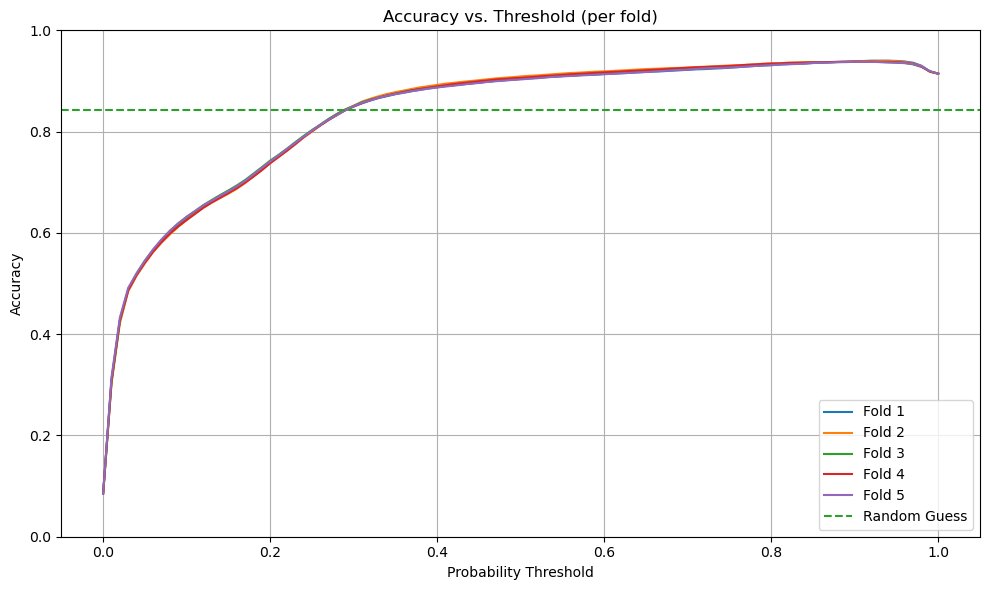

In [21]:
# --- Plot Training Accuracy vs. Threshold ---
plt.figure(figsize=(10, 6))
for fold_idx in range(n_folds):
    plt.plot(thresholds, metrics['accuracy'][fold_idx], label=f'Fold {fold_idx + 1}')

plt.axhline(y=accuracy_guess, linestyle="--", label='Random Guess', color='tab:green')

plt.xlabel('Probability Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold (per fold)')
plt.grid(True)
plt.ylim([0,1])
plt.legend()
plt.tight_layout()
plt.show()

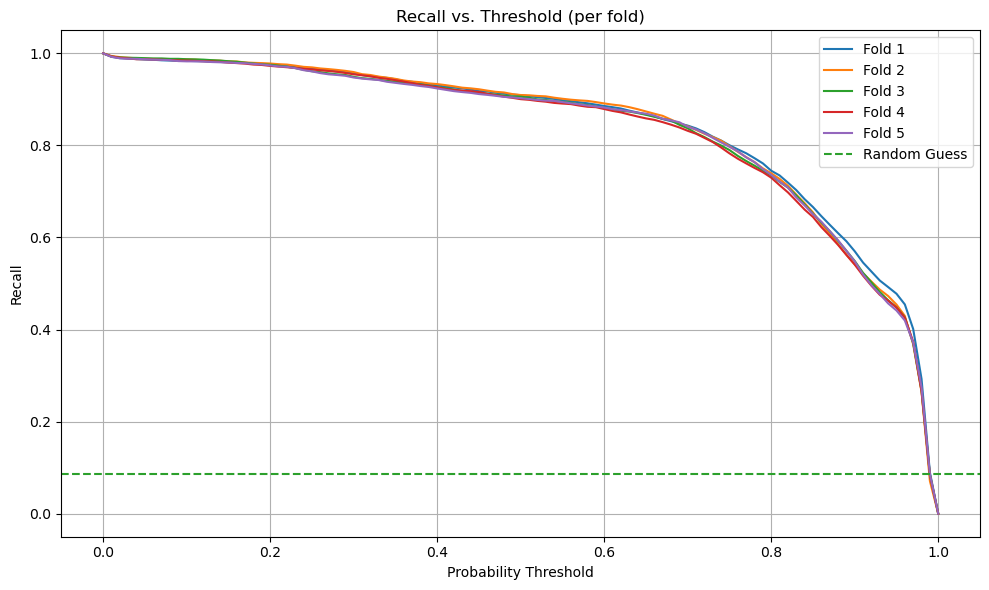

In [22]:
# --- Plot Training Recall vs. Threshold ---
plt.figure(figsize=(10, 6))
for fold_idx in range(n_folds):
    plt.plot(thresholds, metrics['recall'][fold_idx], label=f'Fold {fold_idx + 1}')

#plt.axhline(y=precision_guess, linestyle="--", label='Random Guess', color='tab:green')
plt.axhline(y=recall_guess, linestyle="--", color='tab:green', label='Random Guess')

plt.xlabel('Probability Threshold')
plt.ylabel('Recall')
plt.title('Recall vs. Threshold (per fold)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

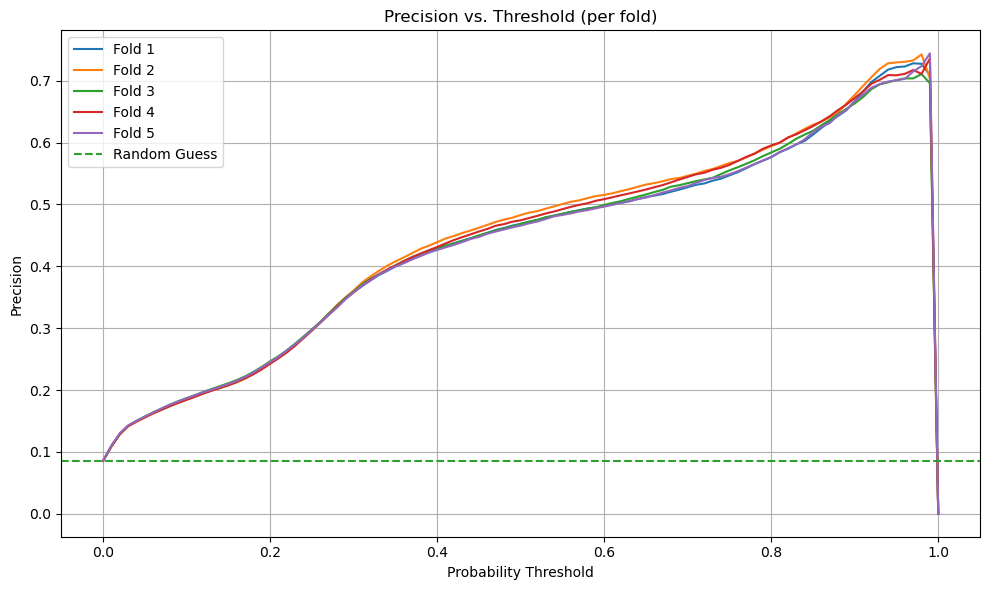

In [23]:
# --- Plot Training Precision vs. Threshold ---
plt.figure(figsize=(10, 6))
for fold_idx in range(n_folds):
    plt.plot(thresholds, metrics['precision'][fold_idx], label=f'Fold {fold_idx + 1}')

#plt.axhline(y=precision_guess, linestyle="--", label='Random Guess', color='tab:green')
plt.axhline(y=precision_guess, linestyle="--", color='tab:green', label='Random Guess')

plt.xlabel('Probability Threshold')
plt.ylabel('Precision')
plt.title('Precision vs. Threshold (per fold)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

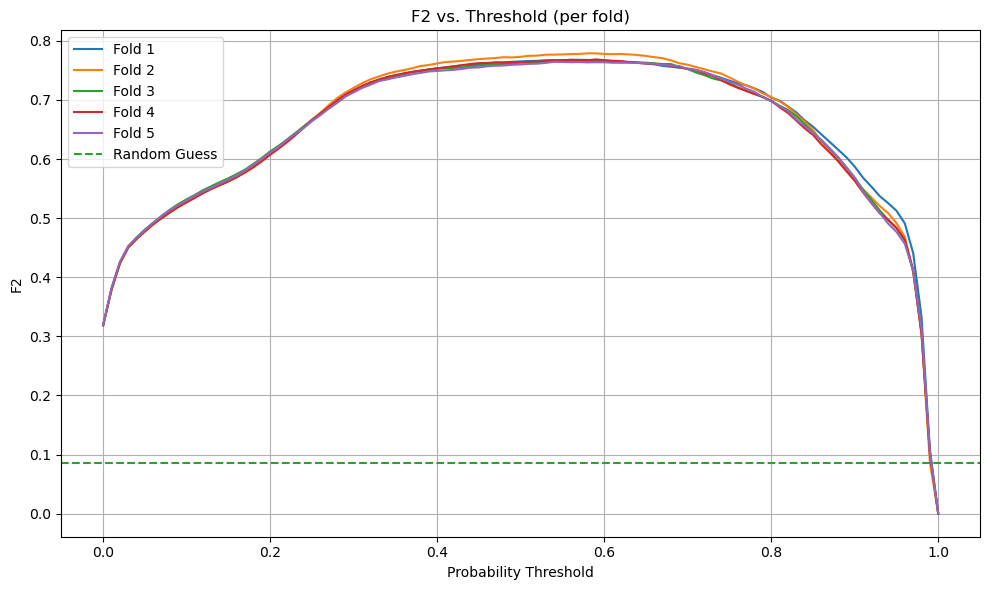

In [24]:
# --- Plot Training f2 score vs. Threshold ---
plt.figure(figsize=(10, 6))
for fold_idx in range(n_folds):
    plt.plot(thresholds, metrics['f2'][fold_idx], label=f'Fold {fold_idx + 1}')

#plt.axhline(y=precision_guess, linestyle="--", label='Random Guess', color='tab:green')
plt.axhline(y=precision_guess, linestyle="--", color='tab:green', label='Random Guess')

plt.xlabel('Probability Threshold')
plt.ylabel('F2')
plt.title('F2 vs. Threshold (per fold)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# It appears that a threhold value of 0.6 maximizes the F2 score and achieves an accuracy above that expected from a random guess

In [26]:
# Check to see that coefficients and intercepts are converging 
print('Coefficient Values:')
print(coefs, '\n')

print('Intercept Values:')
print(intercepts)

Coefficient Values:
[[-2.3141126   1.16666042]
 [-2.28986848  1.14574661]
 [-2.29729966  1.17475428]
 [-2.30280899  1.15519774]
 [-2.31364542  1.17139721]] 

Intercept Values:
[-2.39217271 -2.36179576 -2.38275013 -2.38714946 -2.39884183]


In [27]:
# Coefficients and intercepts seem to be converging as well. 

## Average over splits and summarize results

In [28]:
beta0 = np.mean(intercepts)
beta1 = np.mean(coefs[:,0])
beta2 = np.mean(coefs[:,1])

thresh_target = 0.6
thresh_idx = np.abs(thresholds - thresh_target).argmin()
actual_thresh = thresholds[thresh_idx]

accuracy_avg = np.mean(metrics['accuracy'][:,thresh_idx])
precision_avg = np.mean(metrics['precision'][:,thresh_idx])
recall_avg = np.mean(metrics['recall'][:,thresh_idx])
f2_avg = np.mean(metrics['f2'][:,thresh_idx])

# Print summary
print("===== Model Coefficient Averages =====")
print(f"Intercept (β₀): {beta0:.4f}")
print(f"YEARBLT coefficient (β₁): {beta1:.4f}")
print(f"nn_is_lead_weighted coefficient (β₂): {beta2:.4f}\n")

print(f"===== Performance Metrics at Threshold ≈ {actual_thresh:.2f} =====")
print(f"Accuracy:  {accuracy_avg:.4f} (+{accuracy_avg-accuracy_guess:.4f})")
print(f"Precision: {precision_avg:.4f} (+{precision_avg-precision_guess:.4f})")
print(f"Recall:    {recall_avg:.4f} (+{recall_avg-recall_guess:.4f})")
print(f"F2 Score:  {f2_avg:.4f} (+{f2_avg-f2_guess:.4f})")


===== Model Coefficient Averages =====
Intercept (β₀): -2.3845
YEARBLT coefficient (β₁): -2.3035
nn_is_lead_weighted coefficient (β₂): 1.1628

===== Performance Metrics at Threshold ≈ 0.60 =====
Accuracy:  0.9154 (+0.0720)
Precision: 0.5035 (+0.4179)
Recall:    0.8840 (+0.7984)
F2 Score:  0.7679 (+0.6823)
